# CE9010 Introduction to Data Science Project

# NBA Analysis



This dataset requires a linear learning algorithm.
Model formed at the end of the notebook based on appropriate validation methods used an NBA player's college statistics to predict their 1st and 2nd year impact (measured in advanced statistics).
Prediction of player ability is gaining prominence in the NBA with multiple teams having their own analytical department to ensure the player they drafted is indeed the best player at each available pick of the NBA draft.



## Data Acquisition
 ------






### Data Collection
---
Our main goal is to predict the performance of college prospects in their first and second year of NBA based on their college game performance. Hence we chose to use their advanced statistics available from their college play (WS, Strength of schedule), player's basic stats per 40min as data features and their advanced statistics available in the NBA (PER, BPM, VORP) as the dependent variable to predict for their first two years in the league. 

We chose to extract data from 1996 as college advanced statistics were only available from the 1995 season onwards. We also chose to only include the first 30 draft picks of each draft as players beyond the 30th picks usually do not play significant minutes in their teams.

Player's NBA stats extracted from [Basketball Reference](https://www.basketball-reference.com/).

Player's College stats extracted from [Sports Reference](https://www.sports-reference.com/)





#### Legend
---
PER: Player Efficiency Ratio

WS: Win Shares

BPM: Box Plus/Minus

VORP: Value Over Replacement Player



## Data Scraper


First, we import the relevant libraries.

In [2]:
from bs4 import Comment, BeautifulSoup as bs
import urllib.request
import csv
import traceback
import numpy as np
import pandas as pd
import sys

%matplotlib inline
from IPython.display import set_matplotlib_formats
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from copy import copy
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

### Utility functions

In [3]:
def extract_comments(inside_html, html_id):
    comments = inside_html.findAll(text=lambda text:isinstance(text, Comment)) #data we want is commented, hence the need 
    comments = [comment.extract() for comment in comments if 'id=\"' + html_id + '\"' in comment.extract()] #get advanced stats table
    return bs(comments[0], 'html.parser')

def read_url_into_soup(url):
    try:
        next_page = urllib.request.urlopen(url).read() # goes to player page
        return bs(next_page, 'html.parser')
    except:
        traceback.print_exc()
        return read_url_into_soup(url)

### Scraper
----

#### Warning, long runtime of up to 40 minutes. Program will finish scraping when END OF YEAR: 2016 is printed.

Scraper written using beautifulsoup.


----

#### Problems encountered

---

The main problem encountered when running the scraper is the long runtime for a relatively small dataset of around 500 data cells. The bottleneck occurs when parsing the whole page to look for the link to the sports reference website for each player in order to acquire their respective college stats. This is very inefficient as having to parse the whole page for every player leads to a long runtime. A better solution would be to use another data scraping framework such as Scrapy which allows data extraction using [selectors] (https://doc.scrapy.org/en/latest/topics/selectors.html). Extracting the link to sports-reference website of the page using the XPath or CSS selector would be much quicker than parsing the entire page. However as this scraper would only need to be run once it is not a major concern in our project to optimize and rewrite another scraper.

In [5]:
f = open("data/nba_all.csv", "w")
f2 = open("data/college_all.csv", "w")
writer = csv.writer(f)
writerf = csv.writer(f2)    

for year in range(1996, 2017):
    url = "https://www.basketball-reference.com/draft/NBA_"+ str(year) + ".html"
    html = read_url_into_soup(url)

    
    for row in html.table.tbody.findAll("tr"):

        if (row.find("td")) is None:
            print("END OF YEAR: "+ str(year) +"\n")  # reach end of file
            break
            
        seasons = row.find("td", {"data-stat" : "seasons"} )
        
        if (not seasons.get_text() or  #if player did not play in NBA after being drafted
        int(seasons.get_text()) < 2 or  # if less than 2 seasons played, skip
        len(row.find("td", {"data-stat" : "college_name"}) ) < 1): #if player played in euroleague
            continue
            
        player = row.find("td",{"data-stat" : "player"})
        print(player.get_text())
        inside_html = read_url_into_soup("https://www.basketball-reference.com/" + player.a['href'])

        
        advanced = extract_comments(inside_html, 'advanced')
        
        # STATS
          
        out = [player.string]
        cols = ['per', 'ws_per_48', 'bpm', 'vorp'] # stats to include
        for col in cols:
            out.append(advanced.findAll('td', {'data-stat' : col})[0].string) #include both 1st and 2nd year
            out.append(advanced.findAll('td', {'data-stat' : col})[1].string) 
        out.append(year)
        writer.writerow(out) #write into csv NBA 1st and 2nd year stats
        
        for i in inside_html.findAll("a"): #inefficient way of finding the url for college stats
            if "College Basketball" in str(i):
                coll_url = i['href']
                break
              
        coll_html = read_url_into_soup(coll_url)
        coll_advanced = extract_comments(coll_html, 'players_advanced')
        coll_html = read_url_into_soup(coll_url)
        coll_players_pm = extract_comments(coll_html, 'players_per_min')
        
        
        cols = ['g','gs','fg_per_min','fga_per_min','fg_pct','fg2_per_min','fg2a_per_min','fg2_pct','fg3_per_min',
                'fg3a_per_min','fg3_pct','ft_per_min','fta_per_min','ft_pct','trb_per_min','ast_per_min', 'stl_per_min',
                'blk_per_min', 'tov_per_min','pf_per_min','pts_per_min'] 


        pm = [coll_players_pm.tbody.findAll('td', {'data-stat' : c})[-1].string for c in cols]
        #Basic stats per min
        
        cols = ["mp", "ts_pct","efg_pct","fg3a_per_fga_pct", "fta_per_fga_pct","ws_per_40"]

        adv = [coll_advanced.tbody.findAll('td', {'data-stat' : c})[-1].string for c in cols]
        #Advanced Stats
        
        sos = coll_html.findAll('td', {'data-stat' : 'sos'})[-2].string
        result = [player.string, sos, year]
        result.extend(adv)
        result.extend(pm)
        writerf.writerow(result) #Write into csv final year in college statistics

            
f.close()
f2.close()    

Allen Iverson
Marcus Camby
Shareef Abdur-Rahim
Stephon Marbury
Ray Allen
Antoine Walker
Lorenzen Wright
Kerry Kittles
Samaki Walker
Erick Dampier
Todd Fuller
Vitaly Potapenko
Steve Nash
Tony Delk
John Wallace
Walter McCarty
Roy Rogers
Derek Fisher
Jerome Williams
Brian Evans
Priest Lauderdale
Travis Knight
END OF YEAR: 1996

Tim Duncan
Keith Van Horn
Chauncey Billups
Antonio Daniels
Tony Battie
Ron Mercer
Tim Thomas
Adonal Foyle
Danny Fortson
Tariq Abdul-Wahad
Austin Croshere
Derek Anderson
Maurice Taylor
Kelvin Cato
Brevin Knight
Johnny Taylor
Scot Pollard
Paul Grant
Anthony Parker
Ed Gray
Bobby Jackson
Rodrick Rhodes
John Thomas
Charles Smith
Jacque Vaughn
Keith Booth
END OF YEAR: 1997

Michael Olowokandi
Mike Bibby
Raef LaFrentz
Antawn Jamison
Vince Carter
Robert Traylor
Jason Williams
Larry Hughes
Paul Pierce
Bonzi Wells
Michael Doleac
Keon Clark
Michael Dickerson
Matt Harpring
Bryce Drew
Pat Garrity
Roshown McLeod
Ricky Davis
Brian Skinner
Tyronn Lue
Felipe Lopez
Sam Jacobson
Core

Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1260, in connect
    server_hostname=server_hostname)
  File "/usr/lib/python3.5/ssl.py", line 377, in wrap_socket
    _context=self)
  File "/usr/lib/python3.5/ssl.py", line 752, in __init__
    self.do_handshake()
  File "/usr/lib/python3.5/ssl.py", line 988, in do_handshake
    self._sslo

Jerome Moiso
Etan Thomas
Courtney Alexander
Mateen Cleaves
Jason Collier
Desmond Mason
Quentin Richardson
Jamaal Magloire
Speedy Claxton
Morris Peterson
Donnell Harvey
Mamadou N'Diaye
Erick Barkley
Mark Madsen
END OF YEAR: 2000

Jason Richardson
Shane Battier
Eddie Griffin
Rodney White
Joe Johnson
Kedrick Brown
Richard Jefferson
Troy Murphy
Steven Hunter
Kirk Haston
Michael Bradley
Jason Collins
Zach Randolph
Brendan Haywood
Joseph Forte
Jeryl Sasser
Brandon Armstrong
Gerald Wallace
Samuel Dalembert
Jamaal Tinsley
END OF YEAR: 2001

Mike Dunleavy
Drew Gooden
Dajuan Wagner
Chris Wilcox
Caron Butler
Jared Jeffries
Melvin Ely
Marcus Haislip
Fred Jones
Juan Dixon
Curtis Borchardt
Ryan Humphrey
Kareem Rush
Qyntel Woods
Casey Jacobsen
Tayshaun Prince
Frank Williams
John Salmons
Chris Jefferies
Dan Dickau
END OF YEAR: 2002

Carmelo Anthony
Chris Bosh
Dwyane Wade
Chris Kaman
Kirk Hinrich
T.J. Ford
Mike Sweetney
Jarvis Hayes
Nick Collison
Marcus Banks
Luke Ridnour
Reece Gaines
David West
Dahnta

Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


END OF YEAR: 2005

LaMarcus Aldridge
Adam Morrison
Tyrus Thomas
Shelden Williams
Brandon Roy
Randy Foye
Rudy Gay
Patrick O'Bryant
J.J. Redick
Hilton Armstrong
Ronnie Brewer
Cedric Simmons
Rodney Carney
Shawne Williams
Quincy Douby
Renaldo Balkman
Rajon Rondo
Marcus Williams
Josh Boone
Kyle Lowry
Shannon Brown
Jordan Farmar
Maurice Ager
Mardy Collins
END OF YEAR: 2006

Greg Oden
Kevin Durant
Al Horford
Mike Conley
Jeff Green
Corey Brewer
Brandan Wright
Joakim Noah
Spencer Hawes
Acie Law
Thaddeus Young
Julian Wright
Al Thornton
Rodney Stuckey
Nick Young
Sean Williams
Javaris Crittenton
Jason Smith
Daequan Cook
Jared Dudley
Wilson Chandler
Morris Almond
Aaron Brooks
Arron Afflalo
Alando Tucker
END OF YEAR: 2007

Derrick Rose
Michael Beasley
O.J. Mayo
Russell Westbrook
Kevin Love
Eric Gordon
Joe Alexander
D.J. Augustin
Brook Lopez
Jerryd Bayless
Jason Thompson
Brandon Rush
Anthony Randolph
Robin Lopez
Marreese Speights
Roy Hibbert
JaVale McGee
J.J. Hickson
Ryan Anderson
Courtney Lee
Kosta 

## Data Cleaning

---

#### We saved a copy of college_all and nba_all outside the data/ directory and used it in case we accidentally ran the above function and everything is overwritten

We removed rows and columns of data with missing data as there were years (1997-1998) when some college statistics were not recorded fully.
We also removed one of each pair of highly correlated X variables, to remove multicollinearity and reduce error. Based on our basketball knowledge we chose to keep the variables that are more logically connected to the performance of basketball players. For example, we removed fg_per_min (Field Goals Per Min) and ft_per_min (Field Throws Per Min) in favour of pts_per_min (Points Per Min) as POINTS include both points from FIELD GOALS and points from FREE THROWS, and thus is more comprehensive.

In [10]:
college_df = pd.read_csv('college_all.csv')
college_df.isnull().sum() #check for missing data
college_df.columns = ["Player","sos", "year","mp", "ts_pct","efg_pct","3pt_ar", "fta_per_fga","ws_per_40",
                      'g','gs','fg_per_min','fga_per_min','fg_pct','fg2_per_min','fg2a_per_min','fg2_pct','fg3_per_min',
                      'fg3a_per_min','fg3_pct','ft_per_min','fta_per_min','ft_pct','trb_per_min','ast_per_min',
                      'stl_per_min','blk_per_min', 'tov_per_min','pf_per_min','pts_per_min']

college_df = college_df.drop(columns = ['gs']) #remove column with many empty cells
nba_df = pd.read_csv('nba_all.csv', header=None)
nba_df.columns = ['Player','PER 1st', 'PER 2nd', 'WS48 1st','WS48 2nd',
                  'BPM 1st', 'BPM 2nd','VORP 1st', 'VORP 2nd', 'year']

nba_df = nba_df.drop(['year'], axis=1) #remove duplicate column


### Removal of highly correlated variables

---

In the heat maps below, the areas coloured in yellow means that there is a higher correlation between the two corresponding variables on the axes.

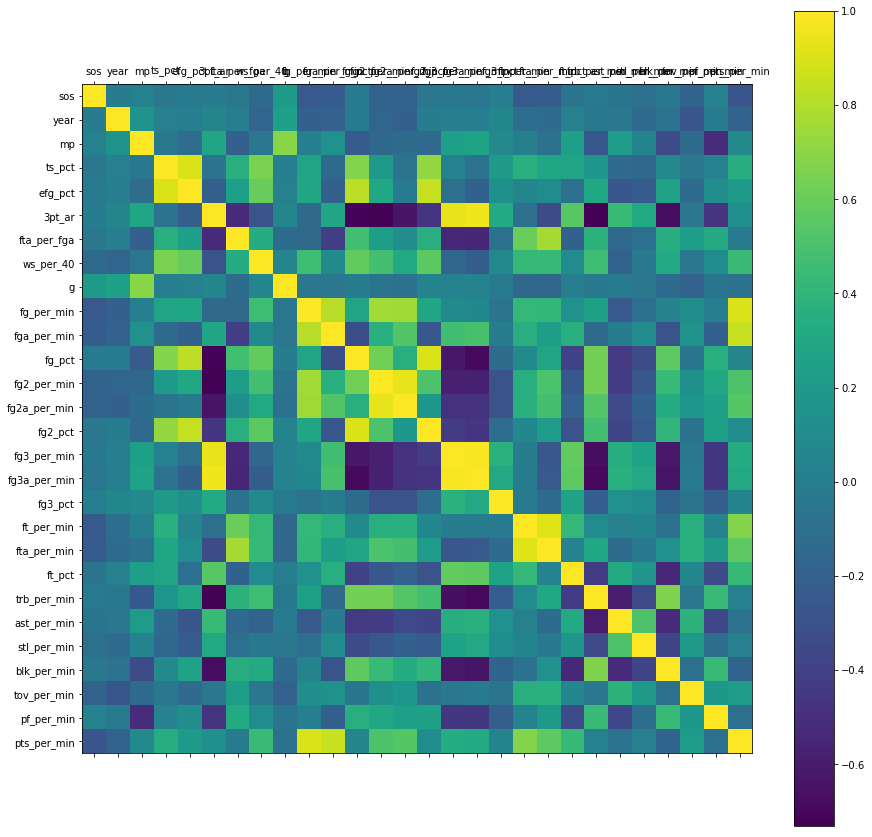

In [11]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.
        df: pandas DataFrame
        size: vertical and horizontal size of the plot
        '''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(corr)
    fig.colorbar(cax)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
plot_corr(college_df, 15)
#drop all high correlations and negative



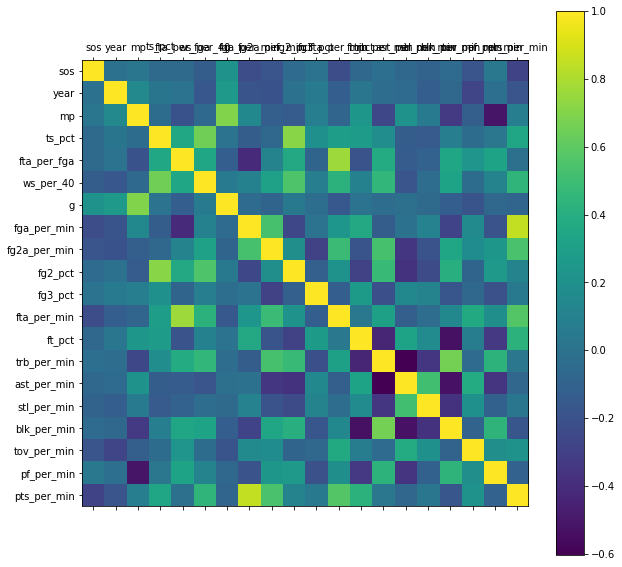

In [12]:
#after removing high correlations
college_df = college_df.drop(columns = ['3pt_ar','efg_pct','fg3_per_min','fg3a_per_min','ft_per_min',
                                         'fg2_per_min','fg_per_min','fg_pct'])
plot_corr(college_df, 10)

## Data Exploration in Pandas

In [15]:
comb = pd.merge(nba_df, college_df, on=['Player', 'Player'])

print("Shape of combined dataframe =",comb.shape)
print("Number of rows to remove =",college_df[college_df.isnull().any(axis=1)].shape[0]) #amount of data to remove
comb = comb.dropna(how = 'any').drop(columns = ['Player']) #remove rows with NaN, and player name
print("Shape of dataframe after removal of NaN rows =",comb.shape)
print("Are there any rows with empty cells?", comb.isnull().values.any() )
comb.head() # display data frame

Shape of combined dataframe = (485, 29)
Number of rows to remove = 85
Shape of dataframe after removal of NaN rows = (400, 28)
Are there any rows with empty cells? False


,PER 1st,PER 2nd,WS48 1st,WS48 2nd,BPM 1st,BPM 2nd,VORP 1st,VORP 2nd,sos,year,...,fg3_pct,fta_per_min,ft_pct,trb_per_min,ast_per_min,stl_per_min,blk_per_min,tov_per_min,pf_per_min,pts_per_min
0,17.8,15.9,0.095,0.022,-0.3,-0.7,0.8,0.7,8.92,1996,...,0.000,9.2,0.700,10.7,2.3,1.3,5.1,3.3,3.4,26.7
1,17.4,21.1,0.049,0.113,-2.0,1.2,0.0,2.3,6.44,1996,...,0.381,10.2,0.683,9.7,1.2,2.1,1.4,3.6,2.4,24.3
2,16.1,16.3,0.077,0.082,-1.0,-0.6,0.6,1.1,12.71,1996,...,0.370,4.9,0.738,3.4,4.8,1.9,0.1,3.4,2.4,20.2
3,14.6,16.2,0.092,0.102,0.3,1.8,1.5,3.2,8.19,1996,...,0.466,5.4,0.810,8.3,4.3,2.2,0.7,3.0,1.7,29.8
4,15.5,17.8,0.027,0.070,-1.0,0.7,0.8,2.2,10.06,1996,...,0.188,5.4,0.631,12.4,4.3,2.5,1.0,3.7,3.5,22.5


## Data Analysis

### Cross validation
---

Here, we split our data into training and validation, and test sets for cross validation. This is for the purpose of estimating the hyper-parameters (cannot be computed by gradient-based techniques) of our model, namely the regularization strength (alpha) and degree of polynomial features (D)

We used the k-fold (4 folds) approach by splitting the the original data into a training set (80%), and a test set (20%). The training set is then split into 4 folds, with 3 folds becoming the training set and one becoming the validation set. We then used these to evaluate the hyper-parameter values, and switched the folds to change the validation set and training set. 

In [16]:
seed = 100 # seed determines the splitting of train and test set

def split_val_set(y_var, no_of_set, X): #We should have just used ShuffleSplit
    '''
    SPLITS SET INTO VAL AND TRAINING SETS and test set
    '''

    X_train, X_test, y_train, y_test = train_test_split(X, comb[y_var], test_size=0.20, random_state=seed)

    splits_x = []
    splits_y = []
    no_of_set = 4
    size_set = int(len(X_train) / no_of_set)
    for i in range(0, no_of_set - 1):
        split_set_x = X_train[size_set * i : size_set * (i+1)] #split first 3 evenly
        split_set_y = y_train[size_set * i : size_set * (i+1)]
        splits_x.append(split_set_x)
        splits_y.append(split_set_y)
    splits_x.append(X_train[size_set*3:]) 
    splits_y.append(y_train[size_set*3:])
    
    return splits_x, splits_y, X_test, y_test


def merge_train(i, xset, yset):
    '''
    merge training sets for each k iteration
    '''
    to_merge_x = [val for index, val in enumerate(xset) if index != i]
    to_merge_y = [val for index, val in enumerate(yset) if index != i]
    return pd.concat(to_merge_x), pd.concat(to_merge_y)

### Finding polynomial degree (D) using K folds Cross validation
---

Code below finds the best hyper parameter D for each Y parameter. Based on the recipe for designing learning systems provided in the lecture notes, we decided to use D = 4 as it has very low training set loss, albeit a high validation set loss

Data was normalised before regression by subtracting the mean and dividing by the euclidean distance using SKLearn (StandardScaler)

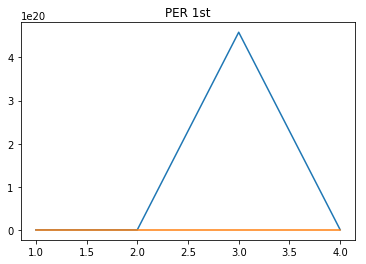

minimised validation set loss w.r.t polynomial degree4= [1.030378170319403, 102.08021075707155, 4.584030342277855e+20, 3.675222216428447e+17]
minimised training set loss w.r.t polynomial degree4= [0.8352123871579752, 0.21610516880941066, 0.0038227228304946437, 0.0038227118639329546]


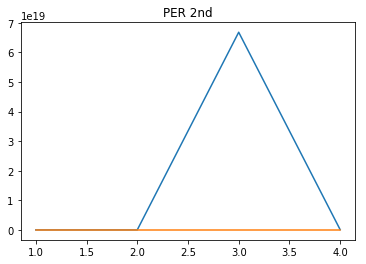

minimised validation set loss w.r.t polynomial degree4= [0.942141192295086, 149.2990425512043, 6.6797537240904016e+19, 8.282130874957757e+16]
minimised training set loss w.r.t polynomial degree4= [0.8114546692569286, 0.03433639136312093, 9.721412207451609e-05, 9.72069517698184e-05]


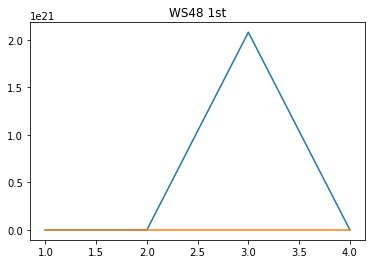

minimised validation set loss w.r.t polynomial degree4= [0.8040369125755898, 96.51324763378798, 2.0798456411978174e+21, 2.4537510780992707e+18]
minimised training set loss w.r.t polynomial degree4= [0.7476347487301832, 0.08079762472124377, 0.0023732496658325146, 0.0023731604298595]


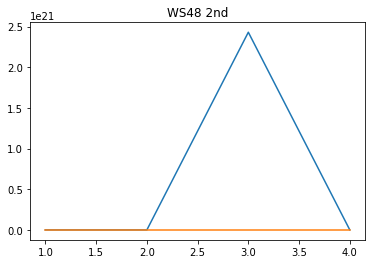

minimised validation set loss w.r.t polynomial degree4= [0.7595427412041651, 129.4715739048134, 2.4300176629227166e+21, 4.805510998357893e+17]
minimised training set loss w.r.t polynomial degree4= [0.7811562136372042, 0.036553967725410114, 0.0020135030810978765, 0.0020133960536090926]


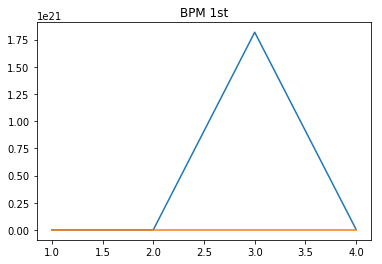

minimised validation set loss w.r.t polynomial degree4= [0.8304156640061716, 105.22669292752103, 1.8175604778544608e+21, 3.449622375244381e+18]
minimised training set loss w.r.t polynomial degree4= [0.7295385324579269, 0.4422993719219924, 0.0010520835466676917, 0.0010520428687458181]


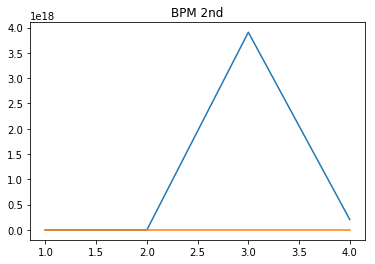

minimised validation set loss w.r.t polynomial degree4= [0.7755180452747359, 84.39851834413832, 3.9067807764667423e+18, 2.0458426431478083e+17]
minimised training set loss w.r.t polynomial degree4= [0.7303202616176738, 0.04707357195394593, 0.0009728957729345726, 0.0009728959697858023]


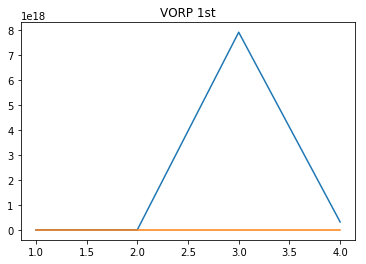

minimised validation set loss w.r.t polynomial degree4= [0.583844948030298, 46.890802511399194, 7.922341459485858e+18, 3.175091459850863e+17]
minimised training set loss w.r.t polynomial degree4= [0.6852513997190102, 0.4145909155195761, 0.0002405832290629137, 0.0002405828910113416]


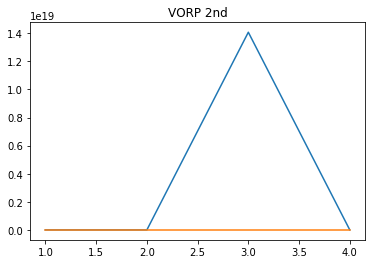

minimised validation set loss w.r.t polynomial degree4= [0.48385024389472564, 62.55496700789085, 1.4074764294587695e+19, 468154219420045.2]
minimised training set loss w.r.t polynomial degree4= [0.7020028342313267, 0.199181160194732, 0.0001245954004699541, 0.00012459467314249789]


In [21]:
no_of_set = 4 #NO OF K 

for y_name in list(nba_df.drop(columns=['Player'])): # iterate through each dependent var
    thing = []
    thing2 = []
    for D in range(1,5):
        poly = PolynomialFeatures(D)
        scaler = StandardScaler()
        old_cols = list(comb) 
        comb = pd.DataFrame(scaler.fit_transform(comb)) #standardizes the whole dataset
        comb.columns = old_cols #scaler fit transform converts it to nparray without the header
        X = comb.iloc[:,8:]
        X = poly.fit_transform(X)
        xset , yset, x_test, y_test = split_val_set(y_name, no_of_set, pd.DataFrame(X)) 
        # xset and yset are training sets split into k sets.
        min_mse = float('inf')
        min_mse_train = float('inf')

        for i in range(no_of_set):
            x_valid = xset[i]
            y_valid = yset[i]
            x_train, y_train = merge_train(i, xset, yset)
            lin_reg_sklearn = LinearRegression()
            lin_reg_sklearn.fit(x_train, y_train)
            
            y_pred = lin_reg_sklearn.predict(x_valid)
            
            mse = mean_squared_error((y_valid), y_pred) #find mean square error for validation set
            
            y_pred_train = lin_reg_sklearn.predict(x_train)
        
            mse_train = mean_squared_error((y_train), y_pred_train) #find mean square error for training set
            
            if min_mse > mse: #finds minimum loss after each k folds variation
                min_mse = mse
   #             best_model = copy(lin_reg_sklearn) # just in case 
            if min_mse_train > mse_train:
                min_mse_train = mse_train
                
        thing.append(min_mse)
        thing2.append(min_mse_train)
    plt.plot(range(1,len(thing)+1), thing)
    plt.plot(range(1,len(thing)+1), thing2)
    plt.title(y_name)
    plt.show()
    print("minimised validation set loss w.r.t polynomial degree " + str(D) + "=", thing)
    print("minimised training set loss w.r.t polynomial degree " + str(D) + "=", thing2)
    
    


### Finding regularisation strength alpha using K-folds cross validation
---

We used Ridge regression to find the optimal regularisation to subject the model to. This allows us to strike a balance between a high variance (needs to increase regularisation) and a high bias (needs to decrease regularisation). Regularisation strength alpha which minimises the gap between training set loss and validation set loss depends on which nba statistic to predict. In this case we set the multiplier to find a minimum gap for WS/48
We found the optimum alpha for WS/48 2nd year = 2.3e5 * 4 = 920 000

Data was normalised before regression by subtracting the mean and dividing by the euclidean distance using SKLearn(StandardScaler).

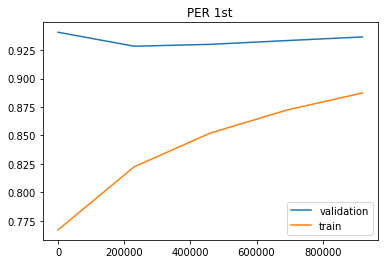

val =  [0.9406015597519058, 0.9283301805070592, 0.9299762129322389, 0.9332627759753042, 0.9364755495610402]
train =  [0.767118279942821, 0.8224976965990595, 0.8520631126010069, 0.8721932592251207, 0.8873321036543803]


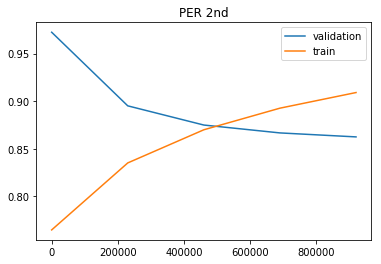

val =  [0.9723405997573437, 0.8950799282991113, 0.8749263213984595, 0.8666623869698572, 0.8624861913633154]
train =  [0.7648417939558709, 0.8351720957980874, 0.8699636128240945, 0.892640449125873, 0.9090453393095945]


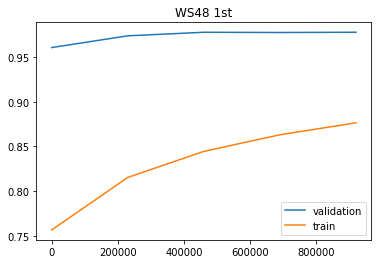

val =  [0.9605119069582185, 0.9736171298694074, 0.9776014669553078, 0.9773349670634641, 0.977625428814138]
train =  [0.7566385722846786, 0.8152992873276771, 0.8444311603984753, 0.8630340492142275, 0.8763458209780252]


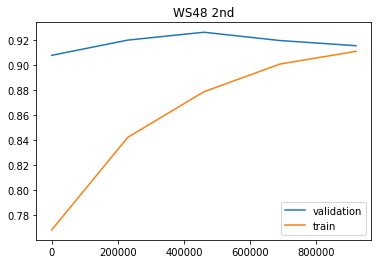

val =  [0.9078580409365171, 0.9200345420788862, 0.9263194963735681, 0.9196958091123303, 0.9155625234980953]
train =  [0.7683431916200548, 0.8422972250090531, 0.8787558455236505, 0.9008921865066551, 0.9110698552625508]


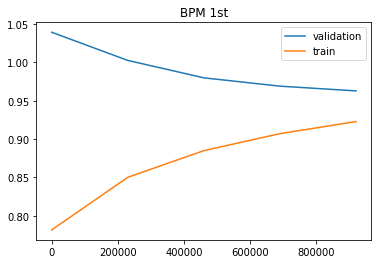

val =  [1.0392519574372217, 1.002537321282575, 0.9798403288209935, 0.9690059437669021, 0.9628296660253429]
train =  [0.7816934379979307, 0.8502125416424943, 0.884977342194943, 0.9071376822130924, 0.9228634469306394]


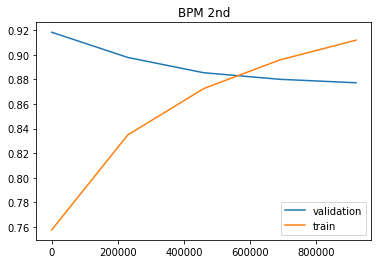

val =  [0.9183022903300133, 0.8978378340635643, 0.885384977229265, 0.8800675567677704, 0.8772521918297927]
train =  [0.7577078228699307, 0.8348669914752432, 0.8725966866006355, 0.8958335023565566, 0.9118723624986401]


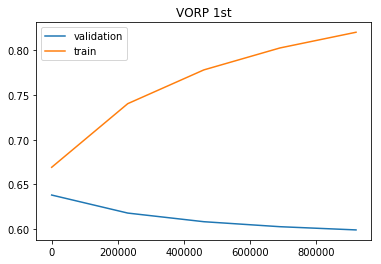

val =  [0.6380418841935744, 0.6178719902118983, 0.6082091391563397, 0.6026231953074902, 0.5990246424143273]
train =  [0.6690826709062346, 0.7402771212610425, 0.77804869715257, 0.8025939393861924, 0.8201739969534839]


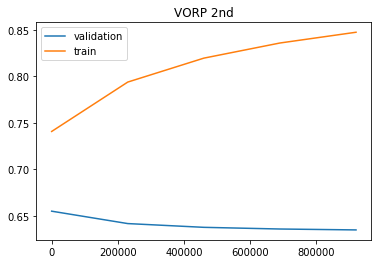

val =  [0.6549873046816078, 0.6416677673867006, 0.637637285509956, 0.635833303679176, 0.6348601648261344]
train =  [0.7406417783215483, 0.7937037208104297, 0.8194181301067582, 0.8356773112984928, 0.8472386895792438]


In [66]:
no_of_set = 4 #NO OF K
multiplier = 2.3e5#by adjusting the multiplier, can find alpha which minimizes gap between validation loss and training loss
for y_name in list(nba_df.drop(columns=['Player'])):
    thing = []
    thing2 = []

    for a in range(1,6):
        poly = PolynomialFeatures(4) #decided to use D = 4
        X = comb.iloc[:,8:] #comb was already scaled just now
        X = poly.fit_transform(X)
        xset , yset, x_test, y_test = split_val_set(y_name, no_of_set, pd.DataFrame(X))
        min_mse = float('inf')
        min_mse_train = float('inf') #both set large values

        for i in range(no_of_set):
            x_valid = xset[i]
            y_valid = yset[i]
            x_train, y_train = merge_train(i, xset, yset)

            lin_reg_sklearn = Ridge(alpha = float(a*multiplier)) 
            lin_reg_sklearn.fit(x_train, y_train)
            
            y_pred = lin_reg_sklearn.predict(x_valid)

            mse = mean_squared_error((y_valid), y_pred)

            y_pred_train = lin_reg_sklearn.predict(x_train)

            mse_train = mean_squared_error((y_train), y_pred_train)
            if min_mse > mse:
                min_mse = mse
                best_model = copy(lin_reg_sklearn)
            if min_mse_train > mse_train:
                min_mse_train = mse_train

        thing.append(min_mse)
        thing2.append(min_mse_train)
    plt.plot([x*multiplier for x in range(5)], thing, label='validation')
    plt.plot([x*multiplier for x in range(5)], thing2,label = 'train')
    plt.title( y_name)
    plt.legend()
    plt.show()
    print("val = ",thing)
    print("train = ",thing2)




## Final Prediction Model

---

We scraped data of promising college basketball players that have not been drafted into the NBA yet. Using our analysis, we develop a model to predict the success of these players in future.

In [88]:
#taking WS/48min 2nd year as Y axis
a = 4 * 2.3e5
#best values
y_name = "WS48 2nd"
X_train, X_test, y_train, y_test = train_test_split(X, comb[y_name])

model = Ridge(alpha = float(a))
model.fit(X_train, y_train)
# model.fit(X, comb[y_name])



Ridge(alpha=920000.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

### Data Scraper for incoming College Players

In [69]:


def get_2018_guy(coll_url, name):


    coll_html = read_url_into_soup(coll_url)
    #         coll_page = urllib.request.urlopen(coll_url).read()
    #         coll_html = bs(coll_page, 'html.parser')


    coll_advanced = extract_comments(coll_html, 'players_advanced')
    coll_html = read_url_into_soup(coll_url)
    coll_players_pm = extract_comments(coll_html, 'players_per_min')


    cols = ['g','gs','fg_per_min','fga_per_min','fg_pct','fg2_per_min','fg2a_per_min','fg2_pct','fg3_per_min',
            'fg3a_per_min','fg3_pct','ft_per_min','fta_per_min','ft_pct','trb_per_min','ast_per_min', 'stl_per_min',
            'blk_per_min', 'tov_per_min','pf_per_min','pts_per_min']

    pm = [coll_players_pm.tbody.findAll('td', {'data-stat' : c})[-1].string for c in cols]

    #input stats
    cols = ["mp", "ts_pct","efg_pct","fg3a_per_fga_pct", "fta_per_fga_pct","ws_per_40"]
    #         for col in cols:
    #         ws40 = coll_advanced.tbody.findAll('td', {'data-stat' : 'ws_per_40'})[-1].string
    adv = [coll_advanced.tbody.findAll('td', {'data-stat' : c})[-1].string for c in cols]

    sos = coll_html.findAll('td', {'data-stat' : 'sos'})[-2].string
    result = [name, sos, "2018"]
    result.extend(adv)
    result.extend(pm)
    return result



## Scraping for college stats data

In [74]:
guys = [("https://www.sports-reference.com/cbb/players/deandre-ayton-1.html","DeAndre Ayton"),
 ("https://www.sports-reference.com/cbb/players/jaren-jacksonjr-1.html", "Jaren Jackson Jr"),
("https://www.sports-reference.com/cbb/players/marvin-bagleyiii-1.html", "Marvin Bagley III"),
("https://www.sports-reference.com/cbb/players/mohamed-bamba-1.html", "Mohamed Bamba"),
 ("https://www.sports-reference.com/cbb/players/trae-young-1.html", "Trae Young")
]
df = pd.DataFrame([get_2018_guy(url, name) for url, name in guys

SyntaxError: invalid syntax (<ipython-input-74-f57c6c468be1>, line 8)

### Data Cleaning for New Data

In [75]:
df.columns = ["Player","sos", "year","mp", "ts_pct","efg_pct","3pt_ar", "fta_per_fga","ws_per_40",
                      'g','gs','fg_per_min','fga_per_min','fg_pct','fg2_per_min','fg2a_per_min','fg2_pct','fg3_per_min',
                      'fg3a_per_min','fg3_pct','ft_per_min','fta_per_min','ft_pct','trb_per_min','ast_per_min',
                      'stl_per_min','blk_per_min', 'tov_per_min','pf_per_min','pts_per_min']

final_df = df.drop(columns = ['gs','3pt_ar','efg_pct','fg3_per_min','fg3a_per_min','ft_per_min',
                                         'fg2_per_min','fg_per_min','fg_pct']) #Drop same values as just now
print(df)
print("Are there any rows with empty cells?", final_df.isnull().values.any() )
#remove column with many empty cells

              Player    sos  year    mp ts_pct efg_pct 3pt_ar fta_per_fga  \
0      DeAndre Ayton   6.84  2018  1172   .650    .625   .078        .424   
1   Jaren Jackson Jr   7.10  2018   764   .647    .595   .414        .573   
2  Marvin Bagley III   9.71  2018  1114   .643    .640   .132        .475   
3      Mohamed Bamba  10.67  2018   906   .593    .567   .189        .441   
4         Trae Young  10.56  2018  1133   .585    .518   .531        .443   

  ws_per_40   g     ...     ft_per_min fta_per_min ft_pct trb_per_min  \
0      .258  35     ...            4.8         6.5   .733        13.8   
1      .239  35     ...            5.5         7.0   .797        10.6   
2      .249  33     ...            4.7         7.5   .627        13.1   
3      .212  30     ...            3.6         5.3   .681        14.0   
4      .201  32     ...            8.3         9.7   .861         4.4   

  ast_per_min stl_per_min blk_per_min tov_per_min pf_per_min pts_per_min  
0         1.9         0

### Prediction

We noticed when we re ran ( X_train, X_test, y_train, y_test = train_test_split(X, comb[y_name]) ),the Model fit is different and the players will be ranked differently.

Hence, we fit the model based on the whole training set to enable consistency and we obtained trae young as the best player.



In [89]:
# print(final_df)
poly = PolynomialFeatures(4)
pred = model.predict(poly.fit_transform(scaler.fit_transform(final_df.drop(columns=['Player']))))
print(sorted([(guys[i][1], pred[i]) for i in range(len(guys))], key = lambda x: x[1], reverse=True ))

model.fit(X, comb[y_name])
pred = model.predict(poly.fit_transform(scaler.fit_transform(final_df.drop(columns=['Player']))))
print(sorted([(guys[i][1], pred[i]) for i in range(len(guys))], key = lambda x: x[1], reverse=True ))

[('Trae Young', 0.043507223833371016), ('Mohamed Bamba', -0.01684359982147599), ('DeAndre Ayton', -0.03535905200346649), ('Marvin Bagley III', -0.036807429952581995), ('Jaren Jackson Jr', -0.04029753936511902)]
[('Trae Young', -0.007156586931457133), ('Mohamed Bamba', -0.032348764895524885), ('DeAndre Ayton', -0.0335023293234068), ('Marvin Bagley III', -0.034873866154786944), ('Jaren Jackson Jr', -0.035386104830711584)]
